In [17]:
import mysql.connector 
import config_aws
import requests
# import time  # This is just to be able to make multiple calls to the API in spaced out time intervals
# import string # For the remove_special_chars function
import pandas as pd
from sodapy import Socrata
import sqlalchemy as db
import pandas as pd
# from helpers import (query, query_list)

In [18]:
#instantiate the connection and table

engine = db.create_engine(f'mysql+mysqlconnector://{config_aws.user}:{config_aws.pw}@{config_aws.host}/building_permits')

connection = engine.connect()
metadata=db.MetaData()

In [19]:
def query(q):
    try:
        return pd.read_sql_query(q, engine)
    # Pass when no data is returned    
    except ResourceClosedError:
        pass

def query_list(col, table, distinct = True):
    elts = ['SELECT',
            'DISTINCT' if distinct else '',
            col,
            'FROM',
            table]
    query_str = ' '.join(elts)
    df = query(query_str)
    l = df.iloc[:,0].tolist()
    return l

**Whitelist only the necessary columns:**

Dependent Variable:
- residential (Y, N)

Categorical:
- self_cert (Y, N, NA)
- zip_code - DROP
- borough (2)
- community_board (36)
- nonprofit (Y, N) likely correlated
- work_type (12 - categorized) now 'cat_work_type'
- job_type (A2, A3, A1, NB, DM, SG)
- permit_type (EW, PL, EQ, AL, NB, FO, SG, DM) # going to be correlated with job_type!
- permittee_liscense_type (GC, MP, FS, OB, SI, NW, OW, RA, PE)
- cat_owner_business_type  
- gis_nta_name (80 different location names, neighborhoods) DROP???
- owner_s_zip_code (2305 total values) - DROP?
- permit_sequence__ (29 options, number of a sequence type)
- gis_council_district (26 options)
- gis_census_tract (861 options) - DROP

-permit_status (NO)

Continuous:
- time_to_issuance (from filing_date, issuance_date)
- time_to_startdate (from job_start_date, issuance_date)

In [29]:
# raw_data = query('SELECT self_cert, non_profit, residential, job_type, work_type, gis_council_district, permittee_s_license_type, borough, issuance_date, filing_date FROM building_permits.dob_permits WHERE dob_permits.borough = "MANHATTAN"')

In [107]:
raw_data = query('SELECT self_cert, non_profit, residential, job_type, work_type, gis_council_district, permittee_s_license_type, borough, permit_type FROM building_permits.nyc_permits')

In [115]:
raw_data.head()

self_cert non_profit residential job_type work_type  gis_council_district  \
0         Y          N          No       NB        PL                    22   
1         N          N         YES       A3        OT                    29   
2         N          N          No       A2        SP                     2   
3         Y          N          No       NB        NA                    22   
4         Y          Y          No       A2        OT                     7   

  permittee_s_license_type    borough permit_type  
0                       MP     QUEENS          PL  
1                       GC     QUEENS          AL  
2                       FS  MANHATTAN          EW  
3                       GC     QUEENS          FO  
4                       GC  MANHATTAN          EW

Text(0.5, 1.0, 'Total Counts for Dependent Variable')

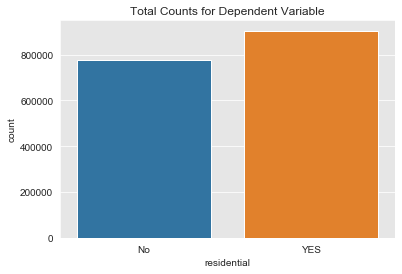

In [109]:
ax = sns.countplot(x='residential', data=raw_data)
ax.set_title('Total Counts for Dependent Variable')


Text(0.5, 1.0, 'Total Counts for Work Type')

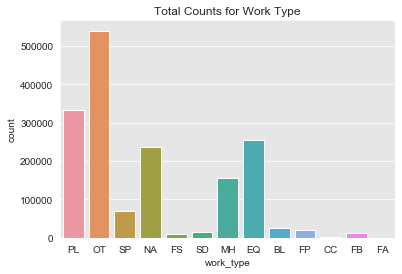

In [121]:
ax = sns.countplot(x='work_type', data=raw_data)
ax.set_title('Total Counts for Work Type')


# **Final data cleaning**

In [22]:
def cat_work(x):
    if x == 'OT':
        return 'Other'
    elif x == 'PL':
        return 'Plumbing'
    elif x == 'EQ':
        return 'Eqipment'
    elif x == 'NA':
        return 'Other'
    elif x == 'MH':
        return 'Mech'     
    elif x == 'SP':
        return 'Internal'
    elif x == 'BL':
        return 'Internal'
    elif x =='SD':    
        return 'External'
    elif x == 'FP':   #all 6 are fuel related
        return 'Fuel'
    elif x == 'FB': 
        return 'Fuel'
    elif x == 'FS':    
        return 'Fuel'
    elif x == 'CC':
        return 'External'
    else:
        return 'Other'



Had to drop ob_type because of data leakage!

In [122]:
def final_clean(data):
     
    data['cat_work_type'] = data['work_type'].map(lambda x: cat_work(x))
    
    data['residential'] = data['residential'].replace({'No': 0, 'YES': 1}) 
    
    data.drop(columns=['work_type'], inplace=True)
     
    return data

In [123]:
final = final_clean(raw_data)

In [124]:
# df =raw_data
final.head()
final.shape
# final['residential']

(1678580, 9)

**Take subset of data** 

- Necessary to run all the tests. Full set taking too long.

In [125]:
df = final.sample(n=100000, random_state=1)
df.shape

(100000, 9)

In [126]:
#drop dependent variable
y = df['residential']
X = df.drop(columns='residential', axis=1)


# **Train Test Split**

In [127]:
#train test split
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [30]:
X_train.shape

(80000, 8)

In [31]:
X_test.shape

(20000, 8)

**DummyClassifier** is a classifier that makes predictions using simple rules. This classifier is useful as a simple baseline to compare with other (real) classifiers. Do not use it for real problems.

In [185]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")

dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [186]:
dummy.score(X_test, y_test)  

0.53295

# **One Hot Encode**

In [128]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

In [129]:
#One-hot encode the training data
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_train)
# ohe.fit(X_test)
X_train_ohe = ohe.transform(X_train) #.toarray()
# X_test_ohe = ohe.transform(X_test).toarray()

# Show:
ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))
ohe_df.head()

self_cert_NA  self_cert_Y  non_profit_Y  job_type_A2  job_type_A3  \
0           0.0          0.0           0.0          0.0          0.0   
1           0.0          0.0           0.0          1.0          0.0   
2           0.0          1.0           0.0          1.0          0.0   
3           0.0          1.0           0.0          1.0          0.0   
4           0.0          1.0           0.0          1.0          0.0   

   job_type_DM  job_type_NB  job_type_SG  gis_council_district_2  \
0          0.0          0.0          0.0                     0.0   
1          0.0          0.0          0.0                     0.0   
2          0.0          0.0          0.0                     0.0   
3          0.0          0.0          0.0                     0.0   
4          0.0          0.0          0.0                     0.0   

   gis_council_district_3  ...  permit_type_FO  permit_type_NB  \
0                     0.0  ...             0.0             0.0   
1                     0.0  ...             0.0             0.0   
2                     0.0  ...             0.0             0.0   
3                     0.0  ...             0.0             0.0   
4                     0.0  ...             0.0             0.0   

   permit_type_PL  permit_type_SG  cat_work_type_External  cat_work_type_Fuel  \
0             1.0             0.0                     0.0                 0.0   
1             0.0             0.0                     0.0                 0.0   
2             1.0             0.0                     0.0                 0.0   
3             1.0             0.0                     0.0                 0.0   
4             0.0             0.0                     0.0                 0.0   

   cat_work_type_Internal  cat_work_type_Mech  cat_work_type_Other  \
0                     0.0                 0.0                  0.0   
1                     0.0                 1.0                  0.0   
2                     0.0                 0.0                  0.0   
3                     0.0                 0.0                  0.0   
4                     0.0                 0.0                  1.0   

   cat_work_type_Plumbing  
0                     1.0  
1                     0.0  
2                     1.0  
3                     1.0  
4                     0.0  

[5 rows x 83 columns]

In [130]:
#One-hot encode the training data
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_test)
X_test_ohe = ohe.transform(X_test)#.toarray()

# Show:
# ohe_df = pd.DataFrame(X_train_ohe, columns=ohe2.get_feature_names(X_train.columns))
# ohe_df.head()

In [131]:
#get column names from the dataframe
col_names = ohe_df.columns

In [132]:
X_train_ohe.shape

(80000, 83)

In [133]:
X_test_ohe.shape

(20000, 83)

# **Decision Tree**

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [135]:
# Create the classifier, fit it on the training data and make predictions on the test set

clf = DecisionTreeClassifier(criterion='entropy', max_depth = 10)

clf.fit(X_train_ohe, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

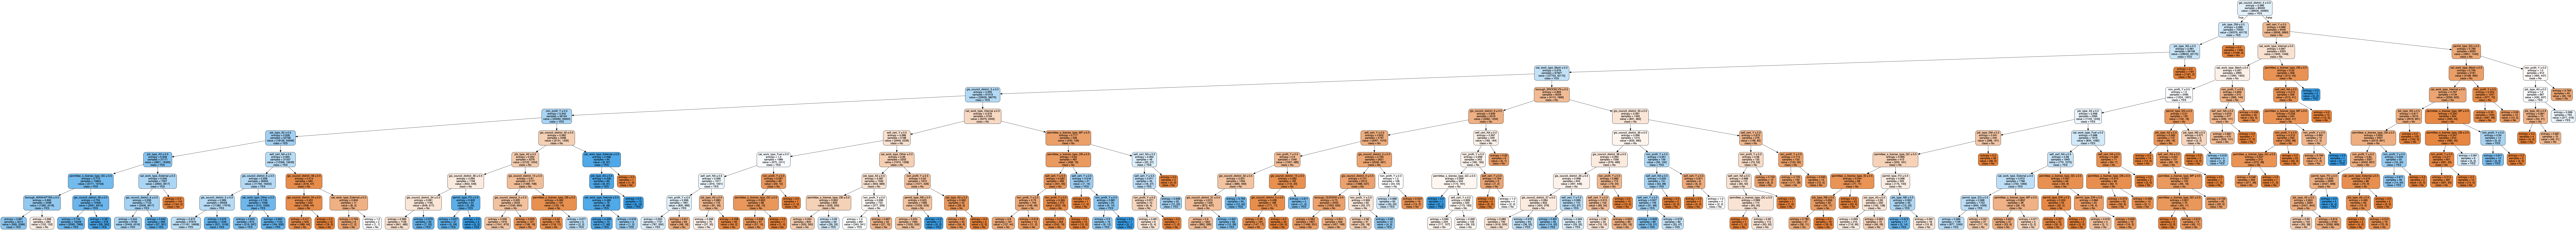

In [136]:
# Create DOT data
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=ohe_df.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, 
                           rounded=True, 
                           special_characters=True)

# graph
graph = graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

In [137]:
X_test_ohe = ohe.transform(X_test)
y_preds = clf.predict(X_test_ohe)


In [138]:
#view feature importances
clf.feature_importances_

array([4.61730871e-02, 3.22237916e-02, 7.06856397e-02, 5.20603589e-02,
       2.68587849e-02, 1.42715843e-01, 9.36539476e-04, 1.22015077e-01,
       0.00000000e+00, 6.38768924e-02, 1.33876556e-01, 1.97113552e-02,
       2.30897666e-02, 0.00000000e+00, 0.00000000e+00, 1.01302385e-03,
       2.16383049e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.50707169e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.55636271e-03, 2.49626165e-03, 1.78914047e-03,
       1.56278572e-03, 0.00000000e+00, 4.93211266e-03, 4.45122884e-04,
       7.07535589e-04, 9.63010444e-04, 0.00000000e+00, 0.00000000e+00,
       6.11051183e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.99329146e-04, 0.00000000e+00,
      

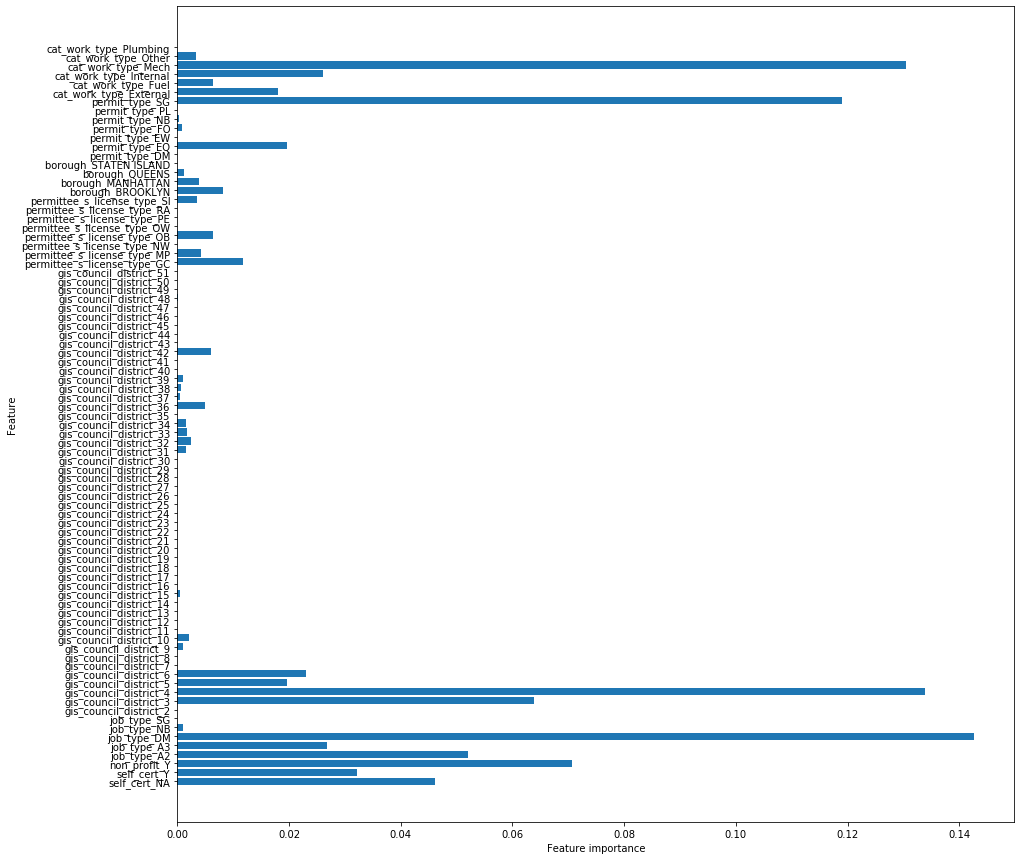

In [41]:
import matplotlib.pyplot as plt

def plot_feature_importances(model):
    
    n_features = X_train_ohe.shape[1]
    
    plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    
    plt.yticks(np.arange(n_features), col_names) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(clf)

**Looks like the important features are:**

- Individual Business type (DUH)
- Work type (mech, fuel, mech)
- City Council District 4 (midtown east, UES, Stytown)
- City Council District 3 (midtown west, Hudson Yards)
- Job Type - SG
- Job Type - A3
- Non Profit Yes (NYCHA?)
- Self Cert Yes (Landlords working on own buildings?)

**Confusion Matrix**

In [ ]:
#make X_test into a dataframe
#make Y_test into a dataframe

In [139]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Test set predictions
prediction = clf.predict(X_test_ohe)

# Confusion matrix and classification report
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

dt_cm = confusion_matrix(y_test, prediction)

[[4250 5091]
 [1325 9334]]
              precision    recall  f1-score   support

          No       0.76      0.45      0.57      9341
         YES       0.65      0.88      0.74     10659

    accuracy                           0.68     20000
   macro avg       0.70      0.67      0.66     20000
weighted avg       0.70      0.68      0.66     20000



Text(0.5, 1, 'Confusion Matrix')

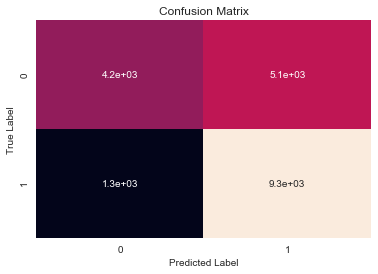

In [140]:
sns.heatmap(dt_cm,annot=True,cbar=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')


# **Random Forest**

In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

Bagging Trees:

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

- n_estimators = The number of base estimators in the ensemble.

In [50]:
bagging_trees = BaggingClassifier(DecisionTreeClassifier(criterion='gini'), 
                                 n_estimators=20)

In [51]:
bagging_trees.fit(X_train_ohe, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

In [151]:
y_predict = clf.predict(X_test_ohe)
y_predict

array(['YES', 'YES', 'YES', ..., 'No', 'YES', 'YES'], dtype=object)

In [52]:
# Training accuracy score
bagging_trees.score(X_train_ohe, y_train)

0.7322125

In [53]:
# Test accuracy score
bagging_trees.score(X_test_ohe, y_test)

0.7054

Fit to Random Forest

In [54]:
# Instantiate and fit a RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train_ohe, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [55]:
# Training accuracy score
random_forest.score(X_train_ohe, y_train)

0.732525

In [56]:
# Test accuracy score
random_forest.score(X_test_ohe, y_test)

0.70645

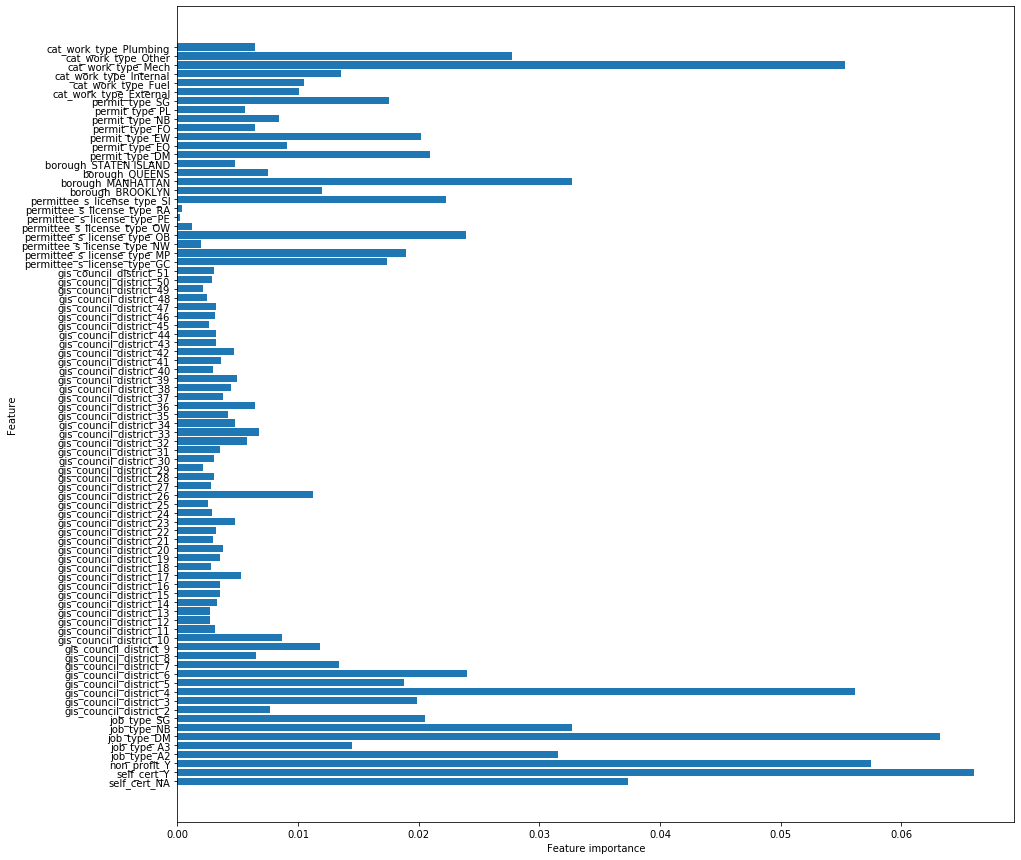

In [157]:

plot_feature_importances(random_forest)

Look at individual trees in the forest!

In [57]:
# Instantiate and fit a RandomForestClassifier
single_forest = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
single_forest.fit(X_train_ohe, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [58]:
# First tree from the forest!
tree_one = single_forest.estimators_[0]

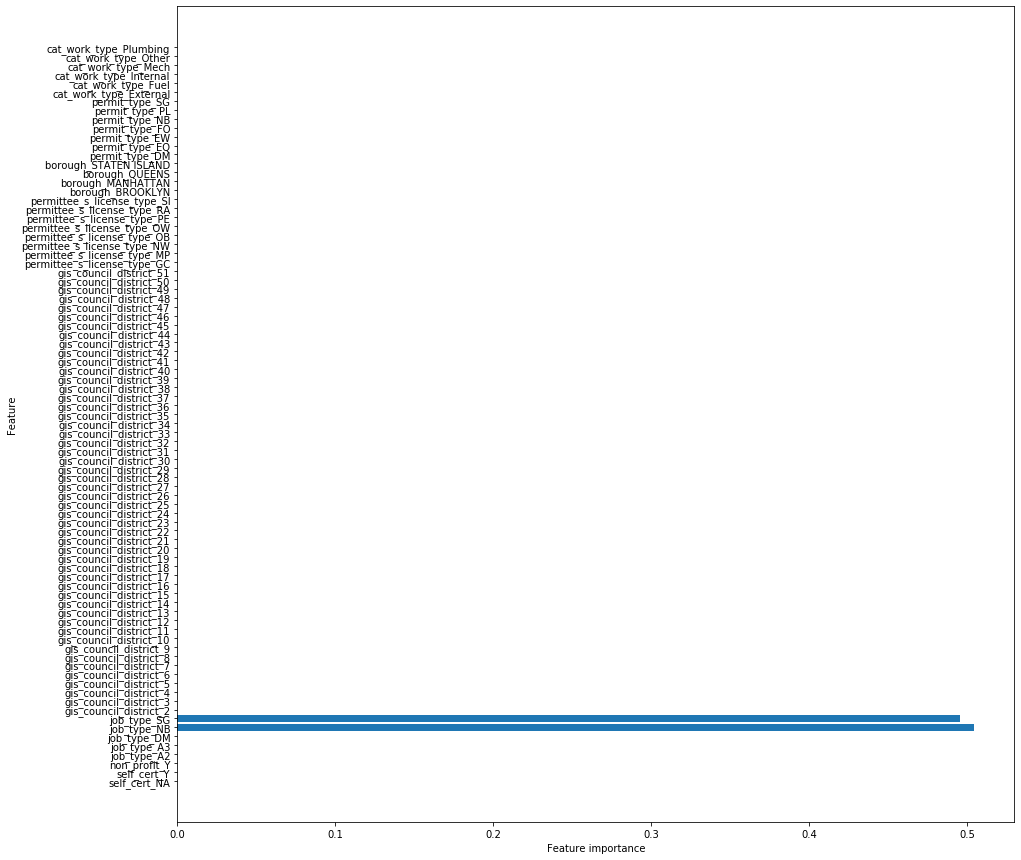

In [160]:
# Feature importance for this single tree
plot_feature_importances(tree_one)

In [163]:
# Second tree from forest
tree_two = single_forest.estimators_[1]

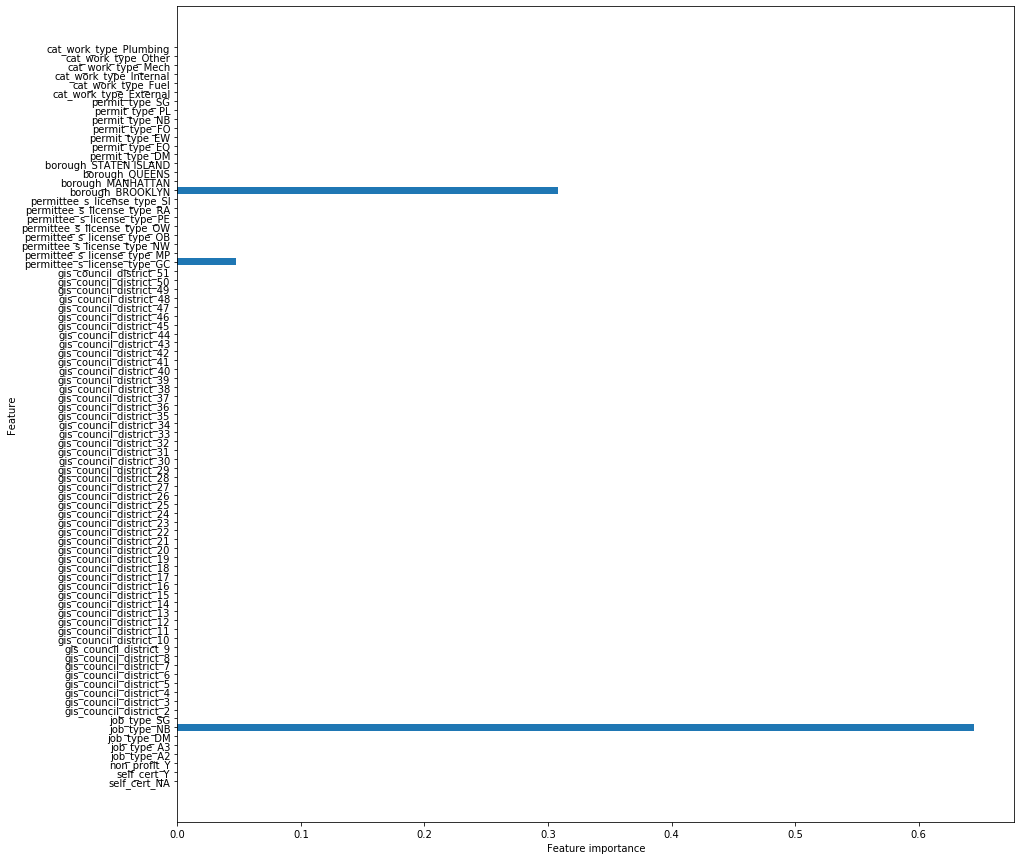

In [164]:
# Feature importance
plot_feature_importances(tree_two)

Confusion Matrix for Random Forest

In [59]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Test set predictions
prediction_forest = random_forest.predict(X_test_ohe)

# Confusion matrix and classification report
print(confusion_matrix(y_test, prediction_forest))
print(classification_report(y_test, prediction_forest))

cm_rf = confusion_matrix(y_test, prediction_forest)

[[5659 3682]
 [2189 8470]]
              precision    recall  f1-score   support

           0       0.72      0.61      0.66      9341
           1       0.70      0.79      0.74     10659

    accuracy                           0.71     20000
   macro avg       0.71      0.70      0.70     20000
weighted avg       0.71      0.71      0.70     20000



In [60]:
rf_fit = random_forest.fit(X_train_ohe, y_train)

In [68]:
rf_prob = rf_fit.predict_proba(X_test_ohe)

In [88]:
rf_prob_true = rf_prob[:,1]

In [89]:
rf_prob_false = rf_prob[:,0]

In [90]:
rf_fit.classes_

array([0, 1])

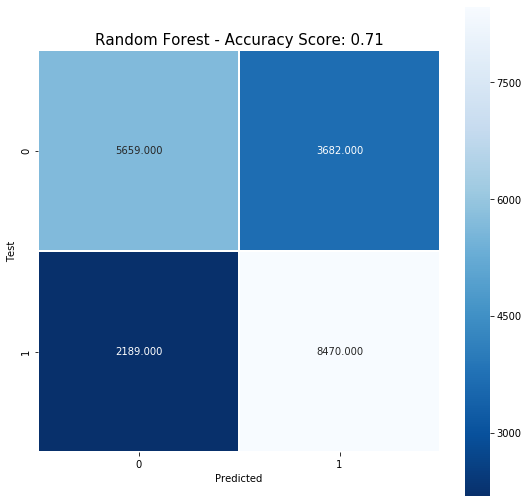

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
#confusion matrix with seaborn
plt.figure(figsize=(9,9))
sns.heatmap(cm_rf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Test');
plt.xlabel('Predicted');
plt.set_xticklabels([''] + labels)
plt.set_yticklabels([''] + labels)
all_sample_title = 'Random Forest - Accuracy Score: 0.71'
plt.title(all_sample_title, size = 15);

In [141]:
import numpy as np
from sklearn.metrics import roc_auc_score
rf_roc_auc =roc_auc_score(y_test, rf_prob_true)
rf_roc_auc

0.7731004182272816

Test AUC: 0.7731004182272816


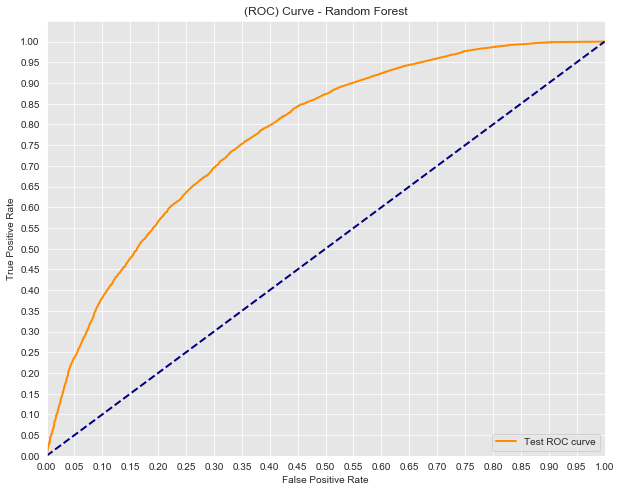

In [73]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, rf_prob_true)

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

# **AdaBoost**

In [74]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [75]:
# Instantiate an AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=40, n_estimators=18, learning_rate=1.0,)

In [76]:
adaboost_clf.fit(X_train_ohe, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=18, random_state=40)

In [77]:
X_train_ohe.shape

(80000, 83)

In [78]:
X_test_ohe.shape

(20000, 83)

In [79]:
# AdaBoost model predictions
adaboost_train_preds = adaboost_clf.predict(X_train_ohe)
adaboost_test_preds = adaboost_clf.predict(X_test_ohe)

In [80]:
print(accuracy_score(y_train, adaboost_train_preds))
print(accuracy_score(y_test, adaboost_test_preds))

0.6836125
0.6799


In [81]:
#product confusion matrix for AdaBoost
print(confusion_matrix(y_test, adaboost_test_preds))
print(classification_report(y_test, adaboost_test_preds))

[[5129 4212]
 [2190 8469]]
              precision    recall  f1-score   support

           0       0.70      0.55      0.62      9341
           1       0.67      0.79      0.73     10659

    accuracy                           0.68     20000
   macro avg       0.68      0.67      0.67     20000
weighted avg       0.68      0.68      0.67     20000



# **Gradient Boosting**

In [82]:
# Instantiate an GradientBoostingClassifier
gbt_clf = GradientBoostingClassifier(random_state=42, )

In [83]:
gbt_clf.fit(X_train_ohe, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [84]:
# model predictions
gbt_train_preds = gbt_clf.predict(X_train_ohe)
gbt_test_preds = gbt_clf.predict(X_test_ohe)

In [85]:
#produce confusion matrix for gradient boosting
print(confusion_matrix(y_test, gbt_test_preds))
print(classification_report(y_test, gbt_test_preds))

cm_gbt = confusion_matrix(y_test, gbt_test_preds)


[[5009 4332]
 [1745 8914]]
              precision    recall  f1-score   support

           0       0.74      0.54      0.62      9341
           1       0.67      0.84      0.75     10659

    accuracy                           0.70     20000
   macro avg       0.71      0.69      0.68     20000
weighted avg       0.71      0.70      0.69     20000



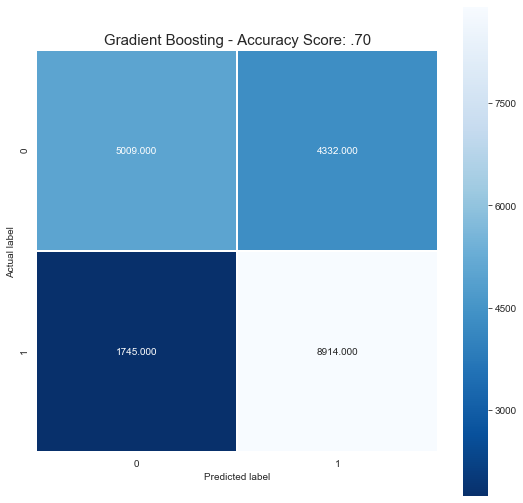

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
#confusion matrix with seaborn
plt.figure(figsize=(9,9))
sns.heatmap(cm_gbt, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Gradient Boosting - Accuracy Score: .70'.format(gbt_test_preds)
plt.title(all_sample_title, size = 15);

In [143]:
import numpy as np
from sklearn.metrics import roc_auc_score
gbt_roc_auc =roc_auc_score(y_test, gbt_test_preds)
gbt_roc_auc

0.6862633362794277

# **Logistic Regression**

In [32]:
df['residential'].value_counts()

YES    53724
No     46276
Name: residential, dtype: int64

In [93]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()

logreg = LogisticRegression().fit(X_train_ohe,y_train)

lr_predictions = logreg.predict(X_test_ohe)

lr_dec = logreg.decision_function(X_test_ohe)

logreg.score(X_test_ohe, y_test)
log_score =logreg.score(X_test_ohe, y_test)

/Users/melissamunz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [228]:
lr_dec

array([ 1.45248174,  0.97451058,  1.31847202, ..., -0.68161187,
        0.55298791,  1.47375089])

In [94]:
#produce confusion matrix for gradient boosting
print(confusion_matrix(y_test, lr_predictions))
print(classification_report(y_test, lr_predictions))
cm =confusion_matrix(y_test, lr_predictions)

[[5501 3840]
 [2413 8246]]
              precision    recall  f1-score   support

           0       0.70      0.59      0.64      9341
           1       0.68      0.77      0.73     10659

    accuracy                           0.69     20000
   macro avg       0.69      0.68      0.68     20000
weighted avg       0.69      0.69      0.68     20000



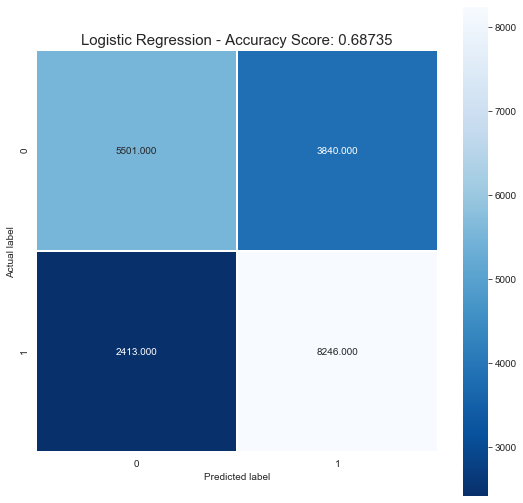

In [235]:
import seaborn as sns
import matplotlib.pyplot as plt
#confusion matrix with seaborn
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Logistic Regression - Accuracy Score: {0}'.format(log_score)
plt.title(all_sample_title, size = 15);

Test AUC: 0.7496692661858847


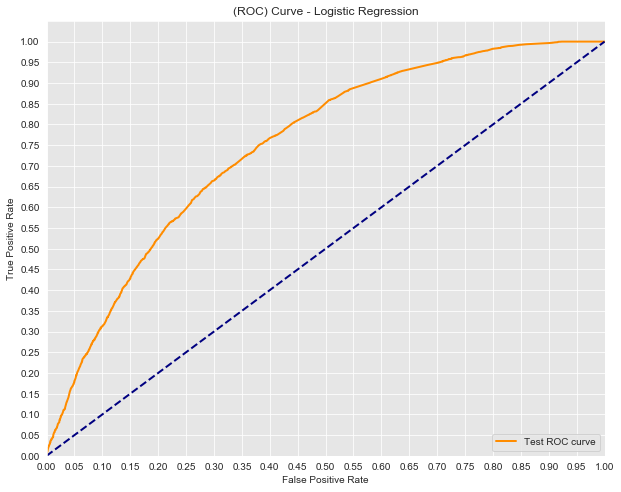

In [204]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, lr_dec)

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# **SVM**

In [205]:
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split  
from time import time

tic = time()
svclassifier = SVC(kernel='rbf', C=1) 
#smaller C, bigger the budget. If too small C, high bias model.
#bigger C, smaller budget. High variance model.
#when svm doesnt work, try different kernals (rbf, linear, sigmoid, poly, etc)

svclassifier.fit(X_train_ohe, y_train) 
svc_y_pred = svclassifier.predict(X_test_ohe)
toc = time()
print("run time is {} seconds".format(toc-tic))


/Users/melissamunz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


run time is 2195.881294965744 seconds


In [206]:
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
print(confusion_matrix(y_test,svc_y_pred))  
print(classification_report(y_test,svc_y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, svc_y_pred)))

[[5504 3837]
 [2458 8201]]
              precision    recall  f1-score   support

           0       0.69      0.59      0.64      9341
           1       0.68      0.77      0.72     10659

    accuracy                           0.69     20000
   macro avg       0.69      0.68      0.68     20000
weighted avg       0.69      0.69      0.68     20000

The accuracy score is 0.68525


**Logistic Regression Coefficients**

In [243]:
dictionary = dict(zip(list(ohe_df.columns), list(logreg.coef_[0])))
dictionary

{'self_cert_NA': -0.8409242398694357,
 'self_cert_Y': -0.41261122391337535,
 'non_profit_Y': -1.2152253595209188,
 'job_type_A2': -0.48864092926774805,
 'job_type_A3': -0.2896415049179437,
 'job_type_DM': -6.281882318869931,
 'job_type_NB': -0.1261604966525932,
 'job_type_SG': -2.8323880824978542,
 'gis_council_district_2': 0.6641424080197396,
 'gis_council_district_3': 0.01903372013915915,
 'gis_council_district_4': -0.2261444772638575,
 'gis_council_district_5': 1.4389764335345938,
 'gis_council_district_6': 1.467013676752059,
 'gis_council_district_7': 1.429977969546338,
 'gis_council_district_8': 0.7745921586611745,
 'gis_council_district_9': 1.4104526582984434,
 'gis_council_district_10': 0.9466685202759638,
 'gis_council_district_11': 0.9405544671509422,
 'gis_council_district_12': 0.5753714227980085,
 'gis_council_district_13': 0.5737358705609747,
 'gis_council_district_14': 1.0236519893821339,
 'gis_council_district_15': 0.8764867371782437,
 'gis_council_district_16': 0.9312950